# Импорт библиотек и загрузка данных

In [357]:
import pandas as pd
import numpy as np

# для визуализации
import matplotlib.pyplot as plt
# для работы с данными
from sklearn.preprocessing import FunctionTransformer
# для разделения  на тренировочную и тестовую выборки
from sklearn.model_selection import StratifiedKFold
# для метрик и baseline моделей
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

import warnings
warnings.filterwarnings("ignore")

In [358]:
#загрузка данных
from google.colab import drive
drive.mount('/content/gdrive')

data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/misel_clear_3.csv')

data.columns

Index(['MaxErr', 'SKO', 'Span', 's22', 'c22', 's31', 'c31'], dtype='object')

In [359]:
data.shape

(29233, 7)

In [360]:
data.dtypes

MaxErr    float64
SKO       float64
Span      float64
s22       float64
c22       float64
s31       float64
c31       float64
dtype: object

In [361]:
num_cols = data.select_dtypes(exclude='object')
data.describe()

,MaxErr,SKO,Span,s22,c22,s31,c31
count,2.923300e+04,29233.000000,29233.000000,29233.000000,29233.000000,29233.000000,29233.000000
mean,1.011628e-02,0.412493,2.502711,-0.275682,-0.160288,0.003978,-0.011631
std,5.587027e-02,0.144696,0.900734,0.505969,0.543716,0.574291,0.572434
min,2.350000e-07,0.076376,0.472445,-1.000000,-1.000000,-1.000000,-1.000000
25%,2.430000e-06,0.287953,1.724830,-0.700000,-0.600000,-0.500000,-0.500000
50%,4.700000e-06,0.461880,2.672020,-0.400000,-0.200000,0.000000,-0.100000
75%,8.130000e-06,0.506623,3.117010,0.100000,0.300000,0.500000,0.500000
max,9.770000e-01,0.748053,4.658830,0.800000,0.800000,1.000000,1.000000


Данные содержат результаты анализа работы численного алгоритма восстановления формы волнового фронта по функции рассеяния точки.
MaxErr является критерием успешной работы алгоритма: если MaxErr <=10E-4, можно считать что алгоритм сошелся, и форма волнового фронта успешно восстановлена.
Форма волнового фронта описывается параметрами с22, s22, c31, s31, успешность восстановления зависит от их сочетания.
SKO и Span являются интегральными оценками волнового фронта, также зависящими от четырех параметров.

# Визуализация

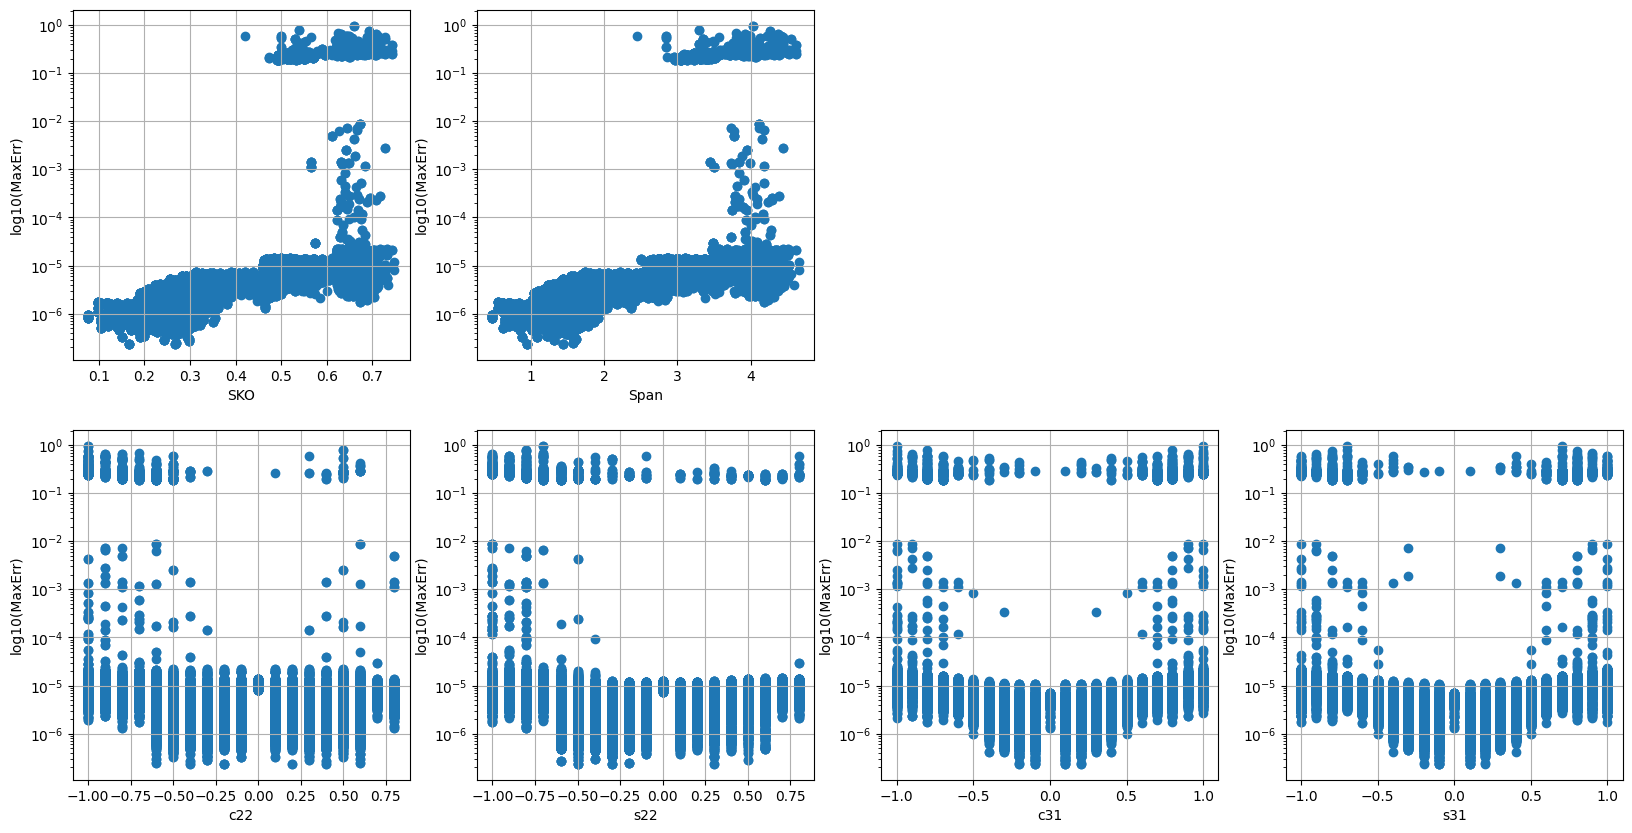

In [349]:
# графики зависимости MaxErr от разных параметров
plt.figure(figsize=(20, 10))

i=1
for col_name in ['SKO', 'Span']:
  plt.subplot(2, 4, i)
  X = data.loc[:, col_name].values
  Y = data.MaxErr.values
  plt.yscale('log')
  plt.scatter(X, Y)
  plt.xlabel(col_name)
  plt.ylabel('log10(' + data.MaxErr.name + ')')
  plt.grid()
  i+=1

i=5
for col_name in ['c22', 's22', 'c31', 's31']:
  plt.subplot(2, 4, i)
  X = data.loc[:, col_name].values
  Y = data.MaxErr.values
  plt.yscale('log')
  plt.scatter(X, Y)
  plt.xlabel(col_name)
  plt.ylabel('log10(' + data.MaxErr.name + ')')
  plt.grid()
  i+=1

Из анализа зависимости итоговой ошибки каждого параметра по отдельности можно сделать вывод, что при возрастании СКО и Span возрастает и ошибка MaxErr, а при СКО<0.4, Span<2.5 ошибка MaxErr всегда находится в допустимом диапазоне.
Задача заключается в том, чтобы более точно определить при каком сочетании параметров происходит успешное восстановление.


# Конструирование признаков
Добавим новую колонку в таблицу, в которой будет записано 1 (алгоритм сошелся) или 0 (алгоритм не сошелся) в зависимости от величины MaxError (MaxError<=10E-4).

In [362]:
# берем колоку с ошибками из таблицы
ErrBinary=data.MaxErr.values
# задаем диапазоны, 1 - алгоритм сошелся, 0 - алгоритм не сошелся
bins = [-np.inf, 10E-5, np.inf]
labels = [1, 0]

transformer = FunctionTransformer(
  func=pd.cut,
  kw_args={'bins': bins, 'labels': labels, 'retbins': False},
)
# создаем новый массим
ErrBinary=transformer.fit_transform(ErrBinary)
# добавляем его к нашим данным
data.insert(0, 'ErrBinary', ErrBinary)
# проверка
data.head()

,ErrBinary,MaxErr,SKO,Span,s22,c22,s31,c31
0,0,0.570488,0.688900,4.29648,-0.7,-1.0,1.0,-0.9
1,0,0.544878,0.654153,4.12908,-0.9,-0.8,0.7,-1.0
2,0,0.412000,0.538129,3.30147,-0.8,-0.5,-0.8,-0.7
3,0,0.412000,0.538129,3.30147,0.8,-0.5,-0.8,0.7
4,0,0.381000,0.742743,4.62505,-0.9,-1.0,-1.0,1.0


success -  28115
failure -  1118


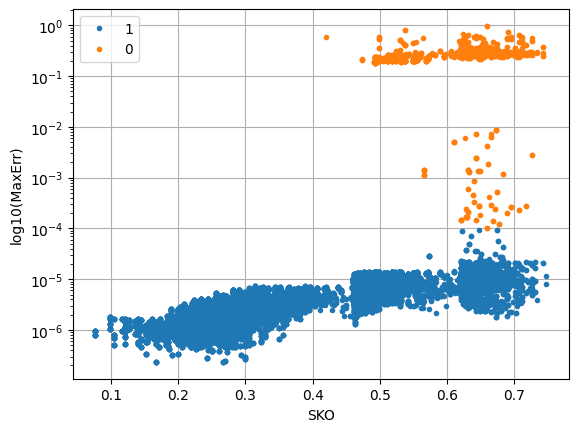

In [363]:
# проверка - сколько 1 и сколько 0?
print('success - ', len(data[data['ErrBinary']==1]))
print('failure - ', len(data[data['ErrBinary']==0]))

# проверка - визуализация с раскраской данных по типу
groups = data.groupby('ErrBinary')

plt.yscale('log')
for name, group in groups:
    plt.plot(group.SKO, group.MaxErr, marker='o', linestyle='', markersize=3, label=name)
plt.legend()
plt.xlabel('SKO')
plt.ylabel('log10(' + data.MaxErr.name + ')')
plt.grid()


# Разделение на тренировочную и тестовую выборки

Создаем массивы для обучения

In [364]:
# классы - колонка ErrBinary
y = data.values[::, 0:1]
# признаки - все кроме MaxErr и ErrBinary
X = data.values[::, 2:]
# MaxErr сохраним отдельно, чтобы потом использовать для проверки
MaxErr = data.values[::, 1:2]

Делим на тренировочную и тестовую выборки

In [365]:
skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y, MaxErr):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    MaxErr_train, MaxErr_test = MaxErr[train_index], MaxErr[test_index]

# проверка
print('y_test  - success - ', np.count_nonzero(y_test==1))
print('y_test  - failure - ', np.count_nonzero(y_test==0))
print('y_train - success - ', np.count_nonzero(y_train==1))
print('y_train - failure - ', np.count_nonzero(y_train==0))


y_test  - success -  5623
y_test  - failure -  223
y_train - success -  22492
y_train - failure -  895


# Выбор метрики
В нашем случае важно не иметь ложно-негативных результатов, когда алгоритма восстановления формы волнового фронта, т.е. можно использовать метрику Precison. Однако, излишнее сужение области положительных предсаказаний тоже не желательно. Поэтому предполагаю, что необходимо использовать Fbeta-score метрику, со смещением в сторону precision. Рассмотрим несколько вариантов метрики.

In [366]:
# DummyClassifier (считаем ее baseline для дальнейшего сравнения) и ее метрики
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train);
print('DummyClassifier:')

y_pred_dummy = dummy_clf.predict(X_test)
print(' precision ', precision_score(y_test, y_pred_dummy, zero_division=0))
print(' F1-score  ', f1_score(y_test, y_pred_dummy))
print(' Fbeta-score (beta 0.5)', fbeta_score(y_test, y_pred_dummy, beta=0.5))

DummyClassifier:
 precision  0.9618542593226137
 F1-score   0.9805562821518876
 Fbeta-score (beta 0.5) 0.969248802013307


In [367]:
# логистическая регрессия и ее метрики
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);
print('LogisticRegression:')

y_pred_log_reg = log_reg.predict(X_test)
print(' precision ', precision_score(y_test, y_pred_log_reg, zero_division=0))
print(' F1-score  ', f1_score(y_test, y_pred_log_reg))
print(' Fbeta-score (beta 0.5)', fbeta_score(y_test, y_pred_log_reg, beta=0.5))

LogisticRegression:
 precision  0.966140350877193
 F1-score   0.972710412434867
 Fbeta-score (beta 0.5) 0.9687576962319248


# Проверка, выводы

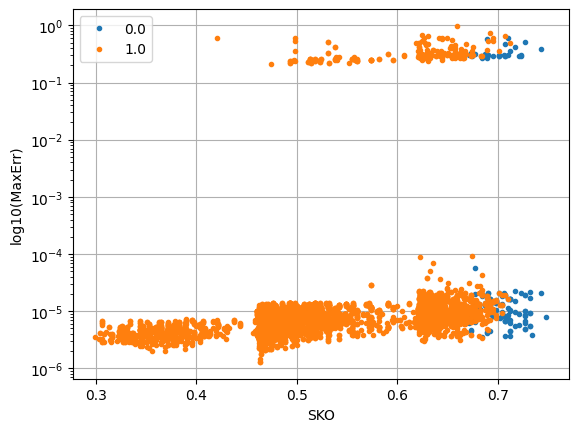

In [368]:
# проверка тестовой выборки - визуализация с раскраской данных по типу
# собираем DataFrame из кусочков, относящихся к тестовой выборке, метод логистической регрессии
test_data = pd.DataFrame(X_test)
test_data.insert(0, '0', y_pred_log_reg)
test_data.insert(1, '1', MaxErr_test)
test_data.columns=data.columns

# группируем и отображаем с раскараской
groups = test_data.groupby('ErrBinary')
plt.yscale('log')
for name, group in groups:
    plt.plot(group.SKO, group.MaxErr, marker='o', linestyle='', markersize=3, label=name)
plt.legend()
plt.xlabel('SKO')
plt.ylabel('log10(' + data.MaxErr.name + ')')
plt.grid()

Из визуализации тестовой выборки видно, что в обученной модели присутствуют как ложно-положительные, так и ложно-отрицательные решения. При этом все метрики довольно высокие, и почти не отличаются от baseline модели:

DummyClassifier precision = 0.961

LogisticRegression precision = 0.966

Кроме того, мы видим, что разделение на тестовую и тренировочную выборки получилось не совсем равномерное по данным, т.к. в тестовой выборке нет данных с ErrMax в диапазоне от 10E-4 до 10E-2.

Выводы:

1. необходимо еще поработать над более равномерным разделением выборки на тестовую и тренировочную
2. возможно имеет смысл уменьшить количество "положительных" данных, т.к. их избыточное количество